# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Add path .. to make relative import

In [2]:
import sys

sys.path.insert(0, '..')

# Import libraries and set rcParams

In [3]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

from matplotlib import rcParams
from numpy.random import choice
from src.preparation.filepaths import *
from src.other.other import find_contours_result

rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = (4, 5)
rcParams['image.cmap'] = 'gray'

# For the first time make fingeprint image read function

In [4]:
# Images types

TYPES = ['.jpg', '.jpeg', '.jpe',
         '.png',
         '.bmp', '.dib',
         '.pbm', '.pgm', '.ppm',
         '.sr', '.ras',
         '.tiff', '.tif']


# Function for checking image type

def check_im_type(name: str):
    """
    check_im_type(name: str) -> bool
    """
    fl = False
    for tp in TYPES:
        if name.endswith(tp):
            fl = True
            break
    return fl


# function for getting

def images_dir_list(listdir):
    return [name for name in listdir if check_im_type(name)]


# Read random function for images

def read_random_image(file_path, with_path=False, flag=cv.IMREAD_GRAYSCALE):
    '''
    read_random_image(file_path, [with_path=False, [flag=cv.IMREAD_GRAYSCALE)
    file_path - file, where images are stored
    with_path - if True return image's filepath and image
    flag - constant values from cv.imread(). Default cv.IMREAD_GREAYSCALE
    '''

    images_list = images_dir_list(os.listdir(file_path))
    image_name = choice(images_list)
    image_path = file_path + image_name

    if with_path:
        return image_path, cv.imread(image_path, flag)
    else:
        return cv.imread(image_path, flag)

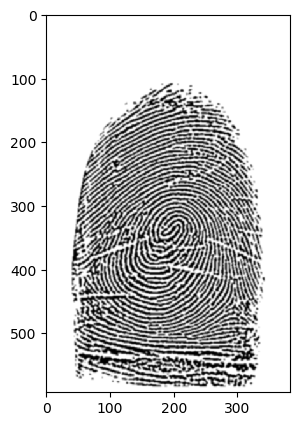

In [5]:

im = read_random_image(RAW_FILE_PATH_GOODIM)
plt.imshow(im)
plt.show()

# Make inverse color function

In [6]:

def invers_color(image):
    if image.mean() > 127.5:
        inv_image = cv.bitwise_not(image)
    else:
        inv_image = image.copy()

    return inv_image

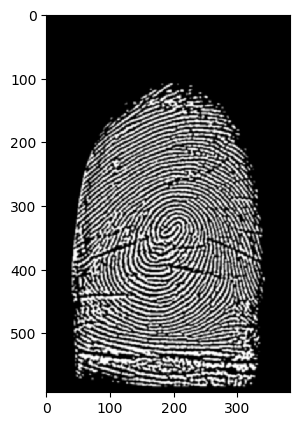

In [7]:

fp_image = invers_color(im)
plt.imshow(fp_image)

# Make function for getting fingerprint image

## Let's show process of cropping fingerprint image

In [8]:

res = cv.findContours(fp_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours, hierarchy = find_contours_result(res)

print("Количество контуров:", len(contours))

Количество контуров: 6


In [9]:
%time

new_contour = np.vstack(contours)
print("\nКоличество точек:", new_contour.shape[0])

CPU times: user 15 µs, sys: 1 µs, total: 16 µs
Wall time: 4.05 µs

Количество точек: 736


## Getting a convex hull

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 3.81 µs

 (593, 383) (39, 107) (345, 586)


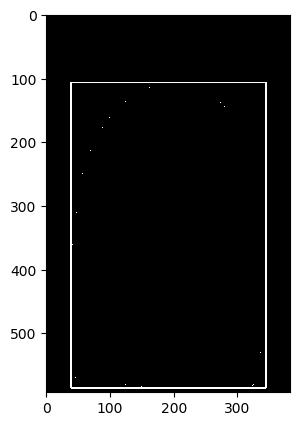

In [10]:
%time

hull = cv.convexHull(new_contour)
BOUND_CONST = 0

x1, y1, width, height = cv.boundingRect(hull)
x2, y2 = x1 + width + BOUND_CONST, y1 + height + BOUND_CONST
x1, y1 = x1 - BOUND_CONST, y1 - BOUND_CONST

if x1 < 0:
    x1 = 0

if y1 < 0:
    y1 = 0

if x2 > fp_image.shape[1]:
    x2 = fp_image.shape[1]

if y2 > fp_image.shape[0]:
    y2 = fp_image.shape[0]

print('\n', fp_image.shape, (x1, y1), (x2, y2))

mask = np.zeros(fp_image.shape)
mask = cv.rectangle(mask, (x1, y1), (x2, y2), 255, 2)

plt.imshow(cv.drawContours(mask, hull, -1, 255), cmap=plt.cm.gray)
pass

# Getting a fingerprint image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


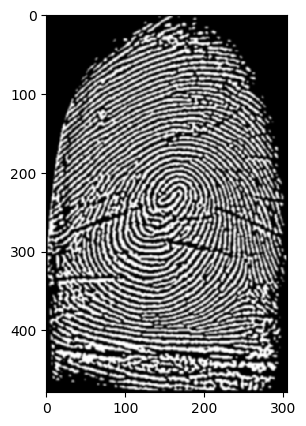

In [11]:
%time

new_image = fp_image[y1:y2, x1:x2]
plt.imshow(new_image, cmap=plt.cm.gray)

pass

## Make function for crop fingerprint image

In [12]:

def crop_fp_image(fp_image, bound_const=5):

    # invert colors (black -> white, white -> black)
    # and binarize image

    temp_image = fp_image

    # get contours and unite contours
    res = cv.findContours(image=temp_image, mode=cv.RETR_EXTERNAL,
                          method=cv.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = find_contours_result(res)

    new_contour = np.vstack(contours)

    # find parameters of bounding rectangle
    x1, y1, width, height = cv.boundingRect(new_contour)
    x2, y2 = x1 + width, y1 + height
    x1, y1 = x1, y1

    # check coordinates of rectangle
    if x1 < 0:
        x1 = 0

    if y1 < 0:
        y1 = 0

    if x2 > temp_image.shape[1]:
        x2 = temp_image.shape[1]

    if y2 > temp_image.shape[0]:
        y2 = temp_image.shape[0]

    # make new image
    resized_image = temp_image[y1:y2, x1:x2]
    resized_image = cv.copyMakeBorder(resized_image, bound_const, bound_const, 
                      bound_const, bound_const, cv.BORDER_CONSTANT, 
                      value=0)

    return resized_image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


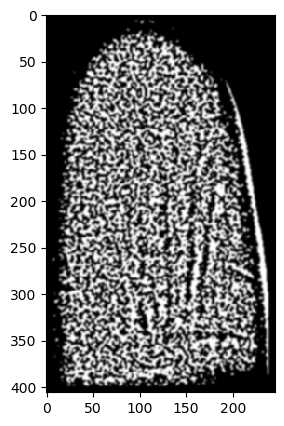

In [13]:
%time

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image)

plt.imshow(crop_image)
plt.show()

# Function for getting image with golden propotion

In [14]:

def get_propotion(im):
    propotion = im.shape[0] / im.shape[1]
    return propotion

In [15]:

def get_golden_ratio_image(im):
    phi = (np.sqrt(5) + 1) / 2
    pr = get_propotion(im)

    if pr > phi:
        new_height = int(im.shape[1] * phi)
        new_im = im[:new_height, :]

        return new_im
    else:
        return im

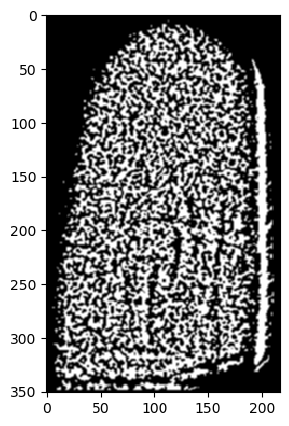

In [16]:

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image)
golden_im = get_golden_ratio_image(crop_image)

plt.imshow(golden_im)
plt.show()


# Make crop function with golden ratio

In [17]:

def crop_fp_image(fp_image, bound_const=5, with_golden_ratio=True):

    # invert colors (black -> white, white -> black)
    # and binarize image

    temp_image = fp_image

    # get contours and unite contours
    res = cv.findContours(image=temp_image, mode=cv.RETR_EXTERNAL,
                          method=cv.CHAIN_APPROX_SIMPLE)

    contours, hierarchy = find_contours_result(res)
    new_contour = np.vstack(contours)

    # find parameters of bounding rectangle
    x1, y1, width, height = cv.boundingRect(new_contour)
    x2, y2 = x1 + width, y1 + height
    x1, y1 = x1, y1

    # check coordinates of rectangle
    if x1 < 0:
        x1 = 0

    if y1 < 0:
        y1 = 0

    if x2 > temp_image.shape[1]:
        x2 = temp_image.shape[1]

    if y2 > temp_image.shape[0]:
        y2 = temp_image.shape[0]

    # make new image
    resized_image = temp_image[y1:y2, x1:x2]
    if with_golden_ratio:
        resized_image = get_golden_ratio_image(resized_image)

    resized_image = cv.copyMakeBorder(resized_image, bound_const, bound_const,
                      bound_const, bound_const, cv.BORDER_CONSTANT, value=0)

    return resized_image

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 4.29 µs


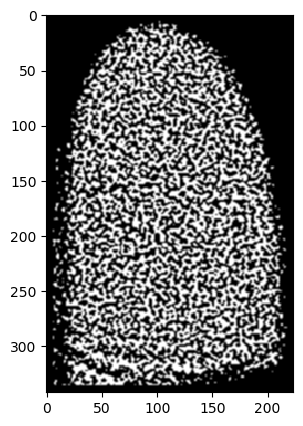

In [18]:
%time

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image, 5, )

plt.imshow(crop_image)
plt.show()

# Resize function

In [19]:

def resize_fp_image(im, new_width=400, interpolation=cv.INTER_LINEAR):

    height, width = im.shape
    k = height/width

    resized_image = cv.resize(im, (new_width, int(new_width*k)),
                              interpolation=cv.INTER_LINEAR)

    return resized_image

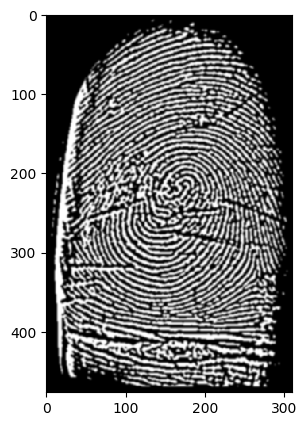

In [20]:

im = read_random_image(RAW_FILE_PATH_GOODIM)
fp_im = invers_color(im)
crop_im = crop_fp_image(fp_im)
resized_im = resize_fp_image(crop_im)

plt.imshow(crop_im)
pass

# Unite all functions to one

In [21]:

def standardize_image(im, bound_const=5, new_width=400,
                      interpolation=cv.INTER_LINEAR, with_golden_ratio=True):

    inv_im = invers_color(im)
    crop_im = crop_fp_image(inv_im, bound_const=bound_const,
                            with_golden_ratio=with_golden_ratio)
    resized_im = resize_fp_image(crop_im, new_width=new_width,
                                 interpolation=interpolation)

    return resized_im


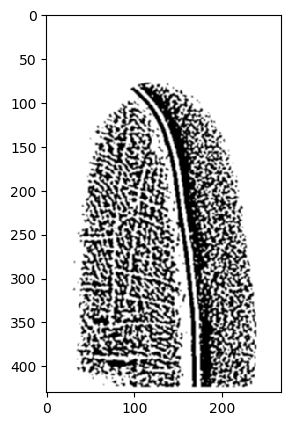

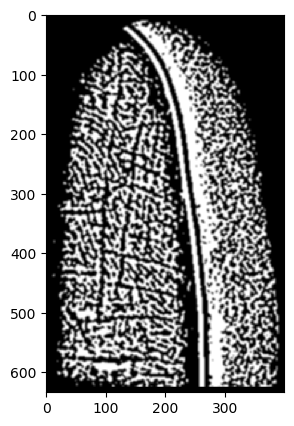

In [22]:
im = read_random_image(RAW_FILE_PATH_BADIM_PANTS)
plt.imshow(im)
plt.show()

fp_im = standardize_image(im)
plt.imshow(fp_im)
plt.show()

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 4.29 µs


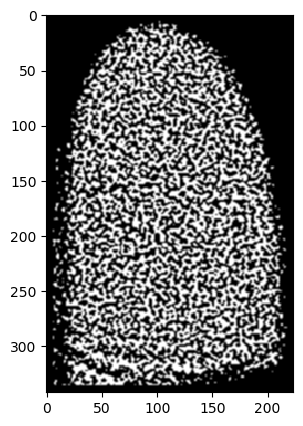

In [23]:
%time

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image, 5, )

plt.imshow(crop_image)
plt.show()

# Resize function

In [24]:

def resize_fp_image(im, new_width=400, interpolation=cv.INTER_LINEAR):

    height, width = im.shape
    k = height/width

    resized_image = cv.resize(im, (new_width, int(new_width*k)),
                              interpolation=cv.INTER_LINEAR)

    return resized_image

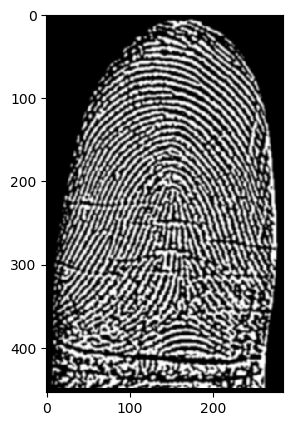

In [25]:

im = read_random_image(RAW_FILE_PATH_GOODIM)
fp_im = invers_color(im)
crop_im = crop_fp_image(fp_im)
resized_im = resize_fp_image(crop_im)

plt.imshow(crop_im)
pass

# Unite all functions to one

In [26]:

def standardize_image(im, bound_const=5, new_width=400, interpolation=cv.INTER_LINEAR, with_golden_ratio=True):

    inv_im = invers_color(im)
    crop_im = crop_fp_image(inv_im, bound_const=bound_const,
                            with_golden_ratio=with_golden_ratio)
    resized_im = resize_fp_image(crop_im, new_width=new_width,
                                 interpolation=interpolation)

    return resized_im


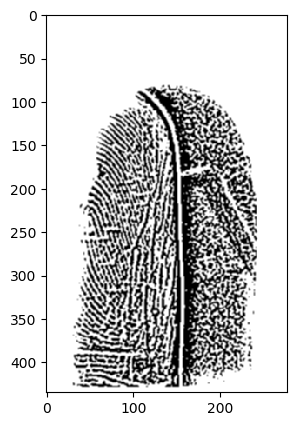

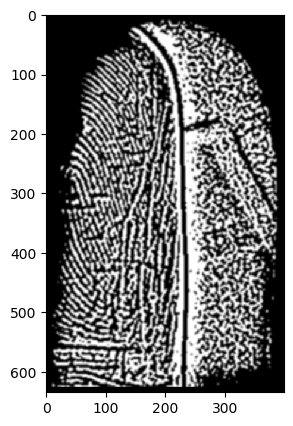

In [27]:
im = read_random_image(RAW_FILE_PATH_BADIM_PANTS)
plt.imshow(im)
plt.show()

fp_im = standardize_image(im)
plt.imshow(fp_im)
plt.show()